In [9]:
import os
import winsound
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
tqdm.pandas()
from multiprocessing import  Pool
import time

import math, collections
from scipy.stats import linregress

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

In [10]:
df_live = pd.read_csv('data\live_preds.csv')
df = df_live[['tick_avg']]
df_live.head()

,predicted_direction,tick_avg,spread_avg,tick_sd,diff,avg_gain,avg_loss,rs,rsi,sema,...,lema,lema_diff,lsma,lsma_diff,ema_diff,sma_diff,max_tick,min_tick,max_gap,min_gap
0,same,1.228242,0.000080,0.000075,0.000214,0.000037,0.000029,1.271766,55.981385,1.228130,...,1.228273,-3.499938e-07,1.228346,0.000003,-0.000143,-0.000195,1.228277,1.228026,0.000035,-0.000215
1,same,1.228369,0.000082,0.000044,0.000127,0.000046,0.000025,1.826305,64.618108,1.228155,...,1.228278,5.027293e-06,1.228350,0.000004,-0.000123,-0.000192,1.228369,1.228026,0.000000,-0.000343
2,same,1.228499,0.000085,0.000032,0.000130,0.000052,0.000025,2.097212,67.712901,1.228193,...,1.228289,1.066024e-05,1.228356,0.000006,-0.000096,-0.000180,1.228499,1.228026,0.000000,-0.000472
3,same,1.228562,0.000075,0.000038,0.000063,0.000052,0.000025,2.070765,67.434823,1.228232,...,1.228301,1.285945e-05,1.228363,0.000007,-0.000069,-0.000173,1.228562,1.228026,0.000000,-0.000535
4,same,1.228641,0.000071,0.000016,0.000079,0.000051,0.000025,2.057184,67.290157,1.228277,...,1.228317,1.575233e-05,1.228371,0.000008,-0.000040,-0.000161,1.228641,1.228026,0.000000,-0.000614


In [11]:
df['diff'] = df['tick_avg'].diff()
df['gain'] = 0
df['loss'] = 0
df['gain'].loc[df['diff'] > 0] = abs(df['diff'])
df['loss'].loc[df['diff'] < 0] = abs(df['diff'])
df['avg_gain'] = df['gain'].rolling(window=14).mean()
df['avg_loss'] = df['loss'].rolling(window=14).mean()
df['ssma'] = df['tick_avg'].rolling(window=20).mean()
df['ssma_diff'] = df['ssma'].diff()
df['lsma'] = df['tick_avg'].rolling(window=50).mean()
df['lsma_diff'] = df['lsma'].diff()
df['sma_diff'] = df['ssma'] - df['lsma']

df['sema'] = df['tick_avg'].ewm(span=20).mean()

del df['gain']
del df['loss']
df = df.dropna()
#df = df.reset_index(drop=True)

In [12]:
df.tail()

,tick_avg,diff,avg_gain,avg_loss,ssma,ssma_diff,lsma,lsma_diff,sma_diff,sema
278,1.227101,-0.000009,0.000049,0.000019,1.226865,0.000013,1.226907,-0.000005,-0.000041,1.226914
279,1.227039,-0.000062,0.000045,0.000024,1.226871,0.000006,1.226903,-0.000004,-0.000031,1.226926
280,1.226944,-0.000095,0.000045,0.000028,1.226874,0.000003,1.226897,-0.000006,-0.000023,1.226927
281,1.226813,-0.000131,0.000045,0.000036,1.226873,-0.000001,1.226892,-0.000005,-0.000019,1.226916
282,1.226750,-0.000063,0.000037,0.000040,1.226872,-0.000001,1.226886,-0.000006,-0.000014,1.226901


In [16]:
df_live[df_live.index.isin(list(df.tail().index))][df.columns]

,tick_avg,diff,avg_gain,avg_loss,ssma,ssma_diff,lsma,lsma_diff,sma_diff,sema
278,1.227101,-0.000009,0.000049,0.000019,1.226865,0.000013,1.226907,-0.000005,-0.000041,1.226925
279,1.227039,-0.000062,0.000045,0.000024,1.226871,0.000006,1.226903,-0.000004,-0.000031,1.226938
280,1.226944,-0.000095,0.000045,0.000028,1.226874,0.000003,1.226897,-0.000006,-0.000023,1.226940
281,1.226813,-0.000131,0.000045,0.000036,1.226873,-0.000001,1.226892,-0.000005,-0.000019,1.226927
282,1.226750,-0.000063,0.000037,0.000040,1.226872,-0.000001,1.226886,-0.000006,-0.000014,1.226910


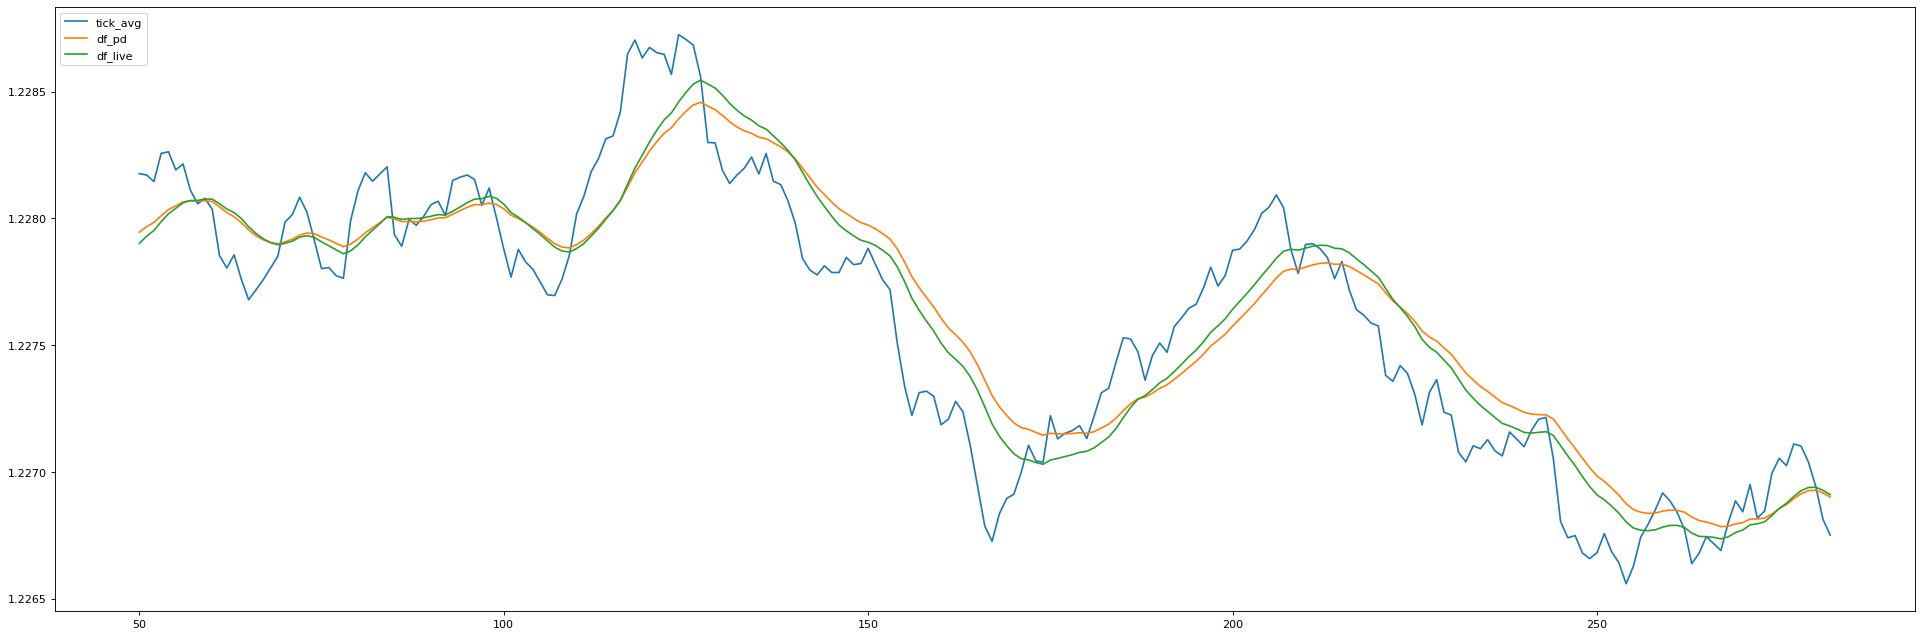

In [27]:
figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
#df_live[df_live.index.isin(list(df.index))]['tick_avg'].plot()

df['tick_avg'].plot(label = 'tick_avg')
df['sema'].plot(label = 'df_pd')
df_live['sema'][50:].plot(label = 'df_live')
plt.legend(loc="upper left")

In [8]:
#list(pd.DataFrame(list(data['ssma_list'])).ewm(span=data['sma_len']).mean()[0])[data['sma_len'] - 1]